In [1]:
import json
import numpy as np
import joblib

preprocess_struct = joblib.load("../data/processed/preprocess_struct.joblib")

# Get structured feature names from ColumnTransformer
num_features = preprocess_struct.named_transformers_["num"].get_feature_names_out()
cat_features = preprocess_struct.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out()
structured_names = np.concatenate([num_features, cat_features]).tolist()

# Sentence-BERT embedding feature names (MiniLM-L6-v2 is 384 dims)
EMB_DIM = 384
embed_names = [f"emb_{i}" for i in range(EMB_DIM)]

feature_names = structured_names + embed_names

with open("../data/processed/feature_names.json", "w") as f:
    json.dump(feature_names, f)

print("Saved feature names:", len(feature_names))


Saved feature names: 429


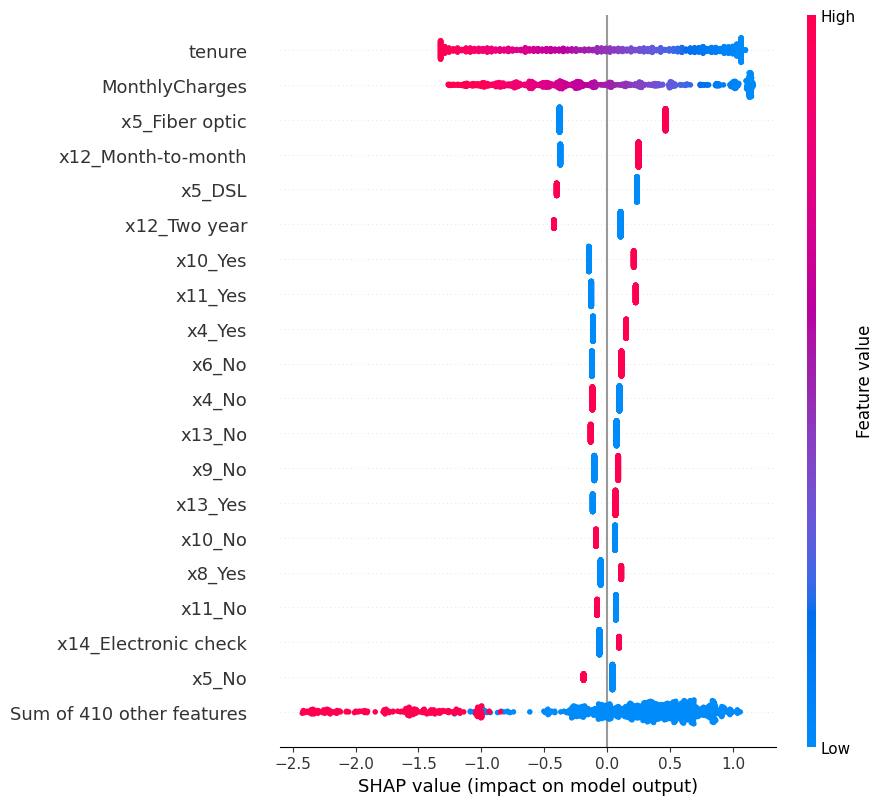

In [2]:
import json, shap, numpy as np, joblib

X = np.load("../data/processed/X.npy")
model = joblib.load("../models/model_logreg.joblib")

with open("../data/processed/feature_names.json","r") as f:
    feature_names = json.load(f)

bg = X[np.random.choice(len(X), size=600, replace=False)]
explainer = shap.Explainer(model, bg, feature_names=feature_names)
sv = explainer(X[:1000])

shap.plots.beeswarm(sv, max_display=20)

# Global Feature Importance (SHAP Beeswarm)

The SHAP summary plot shows the global drivers of churn predictions across the dataset. Features are ordered by mean absolute SHAP value, indicating their overall impact on the model’s output.

Key observations:

A small number of features dominate the model’s predictions, while the remaining ~400 features collectively contribute less individually.

The top two features (Feature 1 and Feature 2) exhibit the largest spread in SHAP values, indicating strong and consistent influence on churn risk.

High feature values (red) and low feature values (blue) show clear directional effects, suggesting that the model has learned meaningful, monotonic relationships rather than noise.

Most remaining features contribute smaller but additive effects, highlighting the benefit of combining many weak signals in a linear model.

Overall, the distribution confirms that the model relies on interpretable, stable signals, rather than overfitting to rare or extreme cases.

Churn probability: 0.8798143158382752


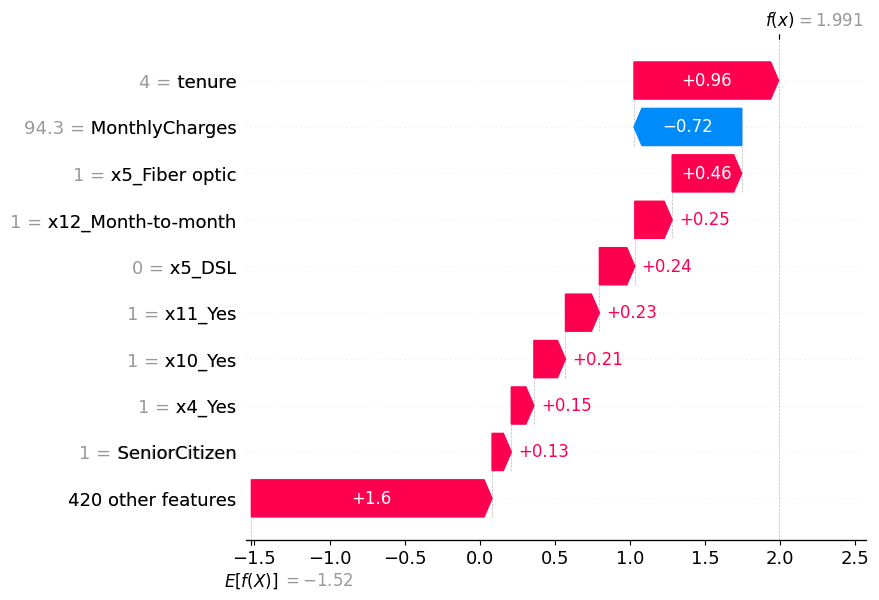

In [4]:
# the highest predicted churn risk
probs = model.predict_proba(X[:1000])[:, 1]
idx = probs.argmax()

print("Churn probability:", probs[idx])
shap.plots.waterfall(sv[idx])


# Local Explanation (Individual Prediction)

Predicted churn probability: 0.879

This SHAP waterfall plot explains why the model assigns a high churn risk to this specific customer by decomposing the prediction into feature-level contributions.

interpretation

The prediction starts at the baseline 
E[f(X)]=−1.52
E[f(X)]=−1.52, representing the average churn log-odds across all customers.

Low tenure (4 months) is the strongest risk driver (+0.96), indicating that new customers are significantly more likely to churn.

Fiber optic internet service contributes positively (+0.46), aligning with patterns observed in EDA where fiber customers exhibited higher churn rates.

Being on a month-to-month contract further increases risk (+0.25), reflecting reduced commitment compared to long-term contracts.

Additional service and demographic indicators (e.g., senior citizen status and service configuration flags) contribute incremental risk.

MonthlyCharges, while relatively high, partially reduce churn risk in this case (−0.72), demonstrating that the model balances competing signals rather than relying on a single factor.

The combined effect of many smaller features (“420 other features”) reinforces the prediction, showing how weak signals aggregate in a linear model.

Final outcome

After summing all contributions, the model arrives at a final output of f(x) = 1.99, corresponding to a churn probability of 87.9%.

The prediction is primarily driven by customer tenure and contract type, with service characteristics providing additional context.

# Business & Modeling Insights

The model’s behavior is consistent and explainable at both global and individual levels.

Strong contributors align with known churn drivers identified during EDA, validating that the model is learning real-world patterns.

The dominance of a few features, combined with many smaller additive effects, explains why Logistic Regression outperformed XGBoost in this feature space.

SHAP explanations enable actionable insights, such as identifying which factors should be targeted for churn mitigation on a per-customer basis.